# 2. 가치 반복 (Value Iteration)

이번 챕터에서는 강화학습의 모델 기반(Model-based) 방법론 중 하나인 **동적 계획법(Dynamic Programming)**, 그중에서도 **가치 반복(Value Iteration)** 알고리즘을 학습한다. 1장에서 정의한 마르코프 결정 과정(MDP)을 기반으로, 에이전트가 어떤 상태에서든 최적의 행동을 선택할 수 있도록 돕는 '가치 함수'를 계산해 본다.

### 0. 라이브러리 및 환경 설정

먼저 필요한 라이브러리를 불러오고, 이전 실습에서 사용한 미로(Maze) 환경을 구성한다. `gymnasium`을 사용하며, 가치 반복을 위해서는 환경의 **전이 확률(Dynamics)**을 알아야 하므로, 이를 확인할 수 있는 기능을 환경 클래스에 포함시킨다.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces

# Jupyter Notebook 내 시각화 설정
%matplotlib inline

In [2]:
class Maze(gym.Env):
    def __init__(self):
        super().__init__()
        self.observation_space = spaces.Discrete(25) # 0~24: 5x5 그리드 평탄화
        self.action_space = spaces.Discrete(4) # 0:Up, 1:Right, 2:Down, 3:Left
        self.state = 0
        self.target = 24 # (4, 4) 위치
        self.row_len = 5
        self.render_mode = 'rgb_array'

        # 가치 반복을 위한 전이 모델 (P) 미리 계산: P[state][action] = [(prob, next_state, reward, done)]
        self.P = {}
        for s in range(25):
            self.P[s] = {}
            for a in range(4):
                self.P[s][a] = []
                # 현재 위치 계산
                row, col = divmod(s, self.row_len)

                # 행동에 따른 이동 (결정론적 환경)
                moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
                dr, dc = moves[a]
                next_row, next_col = row + dr, col + dc

                # 맵 밖으로 나가지 않도록 제한
                next_row = np.clip(next_row, 0, 4)
                next_col = np.clip(next_col, 0, 4)
                next_state = next_row * self.row_len + next_col

                # 보상 및 종료 조건
                done = (next_state == self.target)
                reward = -1.0 # 매 스텝 비용 발생
                if s == self.target: # 목표 지점에서는 이동 불가 (종료 상태)
                     next_state = self.target
                     reward = 0.0
                     done = True

                # (확률 1.0, 다음 상태, 보상, 종료 여부)
                self.P[s][a].append((1.0, next_state, reward, done))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = 0
        return self.state, {}

    def step(self, action):
        # 모델 P를 이용해 step 시뮬레이션
        prob, next_state, reward, done = self.P[self.state][action][0]
        self.state = next_state
        return self.state, reward, done, False, {}

    def render(self):
        # 시각화 코드 (5x5 그리드)
        grid = np.zeros((5, 5, 3), dtype=np.uint8) + 255
        curr_r, curr_c = divmod(self.state, 5)
        target_r, target_c = divmod(self.target, 5)
        grid[curr_r, curr_c] = [0, 0, 255] # 파란색: 에이전트
        grid[target_r, target_c] = [0, 255, 0] # 녹색: 목표
        return np.kron(grid, np.ones((40, 40, 1), dtype=np.uint8))

env = Maze()
print("환경 초기화 완료")

환경 초기화 완료


---

## 1. 가치 반복 (Value Iteration) 이론

가치 반복은 **벨만 최적 방정식(Bellman Optimality Equation)**을 반복적으로 갱신하여 최적 가치 함수 $V^*(s)$를 찾아내는 알고리즘이다.

### 벨만 최적 방정식

이 식은 "현재 상태의 가치는 **취할 수 있는 행동 중 가장 좋은 행동**을 했을 때 얻는 **즉각적 보상**과 **다음 상태의 가치**의 합"이라는 의미를 가진다. 우리는 이 식을 만족할 때까지 모든 상태의 가치를 계속 업데이트한다.

### 1.1 가치 테이블 초기화

모든 상태(25개)에 대한 가치를 저장할 테이블을 0으로 초기화한다.

In [3]:
# 상태 공간의 크기만큼 가치 테이블 생성
value_table = np.zeros(env.observation_space.n)

print(f"초기 가치 테이블 형태: {value_table.shape}")

초기 가치 테이블 형태: (25,)


---

## 2. 가치 반복 알고리즘 구현

이제 핵심 알고리즘을 구현한다. 각 상태에서 가능한 모든 행동을 해보고, 가장 높은 기대 보상을 주는 값을 해당 상태의 새로운 가치로 업데이트한다.

### 2.1 가치 갱신 함수

In [4]:
def value_iteration(env, gamma=0.99, theta=1e-6):
    # 가치 테이블 초기화
    V = np.zeros(env.observation_space.n)

    iteration = 0
    while True:
        delta = 0 # 이번 반복에서 가치 변화량의 최댓값

        # 모든 상태 s에 대해 반복
        for s in range(env.observation_space.n):
            # 목표 상태(종료 상태)의 가치는 0으로 고정 (선택 사항이나 수렴 속도에 도움)
            if s == env.target:
                continue

            # 해당 상태에서 가능한 모든 행동에 대한 기대 가치 계산 (Q-value)
            q_values = []
            for a in range(env.action_space.n):
                # P[s][a]는 [(prob, next_state, reward, done)] 리스트
                prob, next_s, reward, _ = env.P[s][a][0]

                # 벨만 방정식 적용: R + gamma * V(s')
                # 결정론적 환경이므로 합(Sigma) 기호 없이 바로 계산
                q_value = prob * (reward + gamma * V[next_s])
                q_values.append(q_value)

            # 최적 가치 선택 (max)
            best_value = np.max(q_values)

            # 변화량 갱신 (수렴 확인용)
            delta = max(delta, np.abs(best_value - V[s]))

            # 가치 테이블 업데이트
            V[s] = best_value

        iteration += 1

        # 변화량이 임계값(theta)보다 작으면 수렴한 것으로 간주하고 종료
        if delta < theta:
            print(f"가치 반복이 {iteration}회 만에 수렴했다.")
            break

    return V

# 알고리즘 실행
optimal_values = value_iteration(env)
print("계산된 최적 가치 (일부):", optimal_values.reshape(5, 5))

가치 반복이 9회 만에 수렴했다.
계산된 최적 가치 (일부): [[-7.72553056 -6.79346521 -5.85198506 -4.90099501 -3.940399  ]
 [-6.79346521 -5.85198506 -4.90099501 -3.940399   -2.9701    ]
 [-5.85198506 -4.90099501 -3.940399   -2.9701     -1.99      ]
 [-4.90099501 -3.940399   -2.9701     -1.99       -1.        ]
 [-3.940399   -2.9701     -1.99       -1.          0.        ]]


---

## 3. 정책 추출 (Policy Extraction)

가치 반복을 통해 $V^*(s)$를 구했다면, 이를 이용해 최적 정책 $\pi^*(s)$를 추출할 수 있다. 최적 정책은 **각 상태에서 다음 상태의 가치를 최대화하는 행동**을 선택하는 것이다.

In [5]:
def extract_policy(env, value_table, gamma=0.99):
    policy = np.zeros(env.observation_space.n, dtype=int)

    for s in range(env.observation_space.n):
        q_values = []
        # 각 행동에 대해 Q-value 재계산
        for a in range(env.action_space.n):
            prob, next_s, reward, _ = env.P[s][a][0]
            q_value = prob * (reward + gamma * value_table[next_s])
            q_values.append(q_value)

        # 가장 높은 가치를 주는 행동 선택 (argmax)
        policy[s] = np.argmax(q_values)

    return policy

optimal_policy = extract_policy(env, optimal_values)
print("추출된 최적 정책 (0:Up, 1:Right, 2:Down, 3:Left):\n", optimal_policy.reshape(5, 5))

추출된 최적 정책 (0:Up, 1:Right, 2:Down, 3:Left):
 [[1 1 1 1 2]
 [1 1 1 1 2]
 [1 1 1 1 2]
 [1 1 1 1 2]
 [1 1 1 1 0]]


---

## 4. 결과 시각화

계산된 가치와 정책을 시각적으로 확인해 본다. 가치가 높은 곳(목표에 가까운 곳)은 밝게, 낮은 곳은 어둡게 표시하며, 화살표로 최적의 이동 방향을 나타낸다.

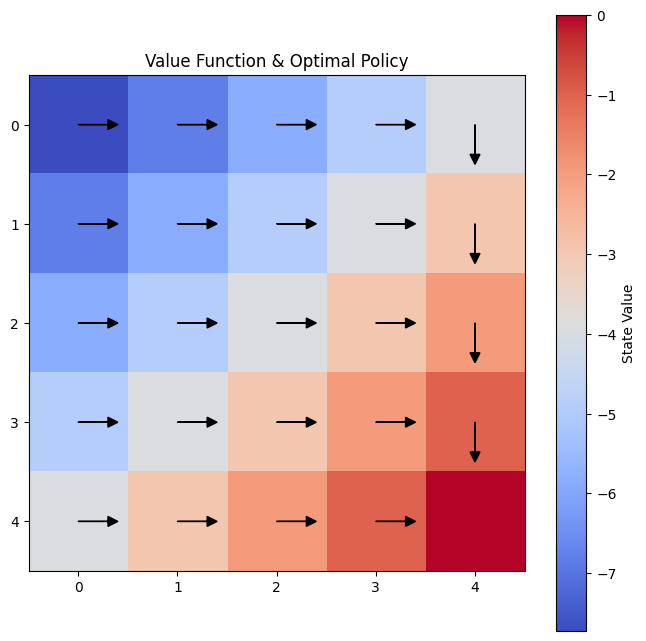

In [6]:
def plot_results(values, policy):
    # 가치 함수 히트맵 그리기
    plt.figure(figsize=(8, 8))
    plt.imshow(values.reshape(5, 5), cmap='coolwarm', interpolation='none')
    plt.colorbar(label='State Value')
    plt.title("Value Function & Optimal Policy")

    # 정책 화살표 그리기
    arrows = {0: (0, -0.3), 1: (0.3, 0), 2: (0, 0.3), 3: (-0.3, 0)} # (dx, dy)

    for s in range(25):
        if s == 24: continue # 목표 지점은 화살표 생략

        r, c = divmod(s, 5)
        action = policy[s]
        dx, dy = arrows[action]

        # 화살표 추가 (x는 열, y는 행이므로 순서 주의)
        plt.arrow(c, r, dx, dy, head_width=0.1, head_length=0.1, fc='black', ec='black')

    plt.show()

plot_results(optimal_values, optimal_policy)

### 결과 분석

위 그래프를 통해 다음을 확인할 수 있다.

1. **가치 분포:** 목표 지점((4,4), 우측 하단)에 가까울수록 가치가 높고(붉은색), 멀어질수록 낮다(파란색). 이는 목표까지 도달하는 데 걸리는 스텝 수가 적을수록 누적 패널티(-1)를 덜 받기 때문이다.
2. **최적 경로:** 검은색 화살표를 따라가면 어느 위치에서 시작하더라도 최단 거리로 목표 지점에 도달할 수 있다.

---

## 5. 시뮬레이션

마지막으로, 구한 최적 정책을 사용하여 에이전트가 실제로 길을 잘 찾는지 확인해 본다.

이동 경로: [0, np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(9), np.int64(14), np.int64(19), np.int64(24)]
총 8 스텝 소요


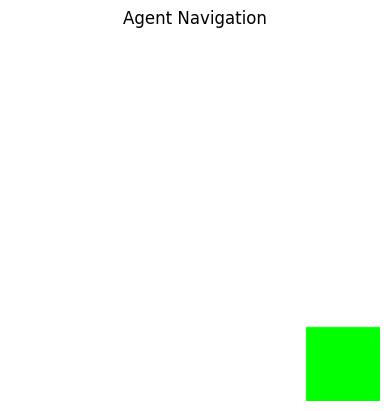

In [12]:
import IPython.display as ipd

ipd.display(plt.gcf())
ipd.clear_output(wait=True)

# 에피소드 실행 함수
def run_episode(env, policy):
    state, _ = env.reset()
    done = False
    step = 0
    path = [state]

    img = plt.imshow(env.render())
    plt.axis('off')
    plt.title("Agent Navigation")

    while not done and step < 20: # 최대 20스텝 제한
        action = policy[state]
        next_state, reward, done, _, _ = env.step(action)

        state = next_state
        path.append(state)
        step += 1

        img.set_data(env.render())
        ipy_display(plt.gcf())
        clear_output(wait=True)

    print(f"이동 경로: {path}")
    print(f"총 {step} 스텝 소요")

run_episode(env, optimal_policy)